# Welcome to the third machine learning application
This notebook is the third of a series of machine learning applications using Python. The objective is to apply to real dataset powerful techniques to unleash company's growth. The objective here is to create a classification model to predict if a customer is sensitive to coupons or not.

### What is a classification model ?
Classification is a predictive modeling model where a class label is predicted for specific input data. Here our class labels will be either a customer is Sensitive or Not sensitive to coupons. Hence our model is a binary classification task.

# Libraries Importation
First step is to import the libraries we need to do our Exploratory Data Analysis phase and later build our model

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Exploratory Data Analysis
EDA is a multiple steps process that enables us to understand our dataset and prepare it in order to have the best possible model

## 1. Data Importation
First step is to load and read the data.
The data is provided by dunhumby company and contain household level transactions over two years from a group of 2500 households who are frequent shoppers at a retailer. Additionaly to the transactional data, demographics and direct marketing contact history are also provided.
Let's imagine we are responsible of the marketing campaigns at this retail firm. We know 70% of our customers never use the coupons they receive and this lead to money loss for our company. Our objective is to create a predictive model to know to which customers we should send coupons for the last 5 campaigns of the year.
### Files description

- Campaign Descriptions (campaigndesc.csv)
- Campaigns (campaign_table.csv)
- Coupons (coupon.csv)
- Coupon Redemptions (coupon_redempt.csv)
- Transactions (transaction_data.csv)
- Demographics (hh_demographic.csv)

### Demographics data
This table contains several demographics information concerning 802 regular customers. let's load the data and start an exploratory data analysis 

In [2]:
df = dict()
df["hh_demographic"] = pd.read_csv("hh_demographic.csv")
demographic=df["hh_demographic"]
demographic["MARITAL_STATUS_CODE"].replace(['A', 'B', 'U'],['Married','Unknown','Single'],inplace=True)

demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,Single,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,Single,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,Unknown,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,Married,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,Single,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [3]:
#Lets create a function to plot the distribution of each features in our dataset
def pie_categorical(data):
    features = data.columns
    fig_pie_cat = plt.figure(figsize=(15,15))
    count = 1
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_pie_cat.add_subplot(rows,cols,count)
        data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
        plt.ylabel("")
        plt.title(i,fontweight="bold",fontsize=8)
        count += 1

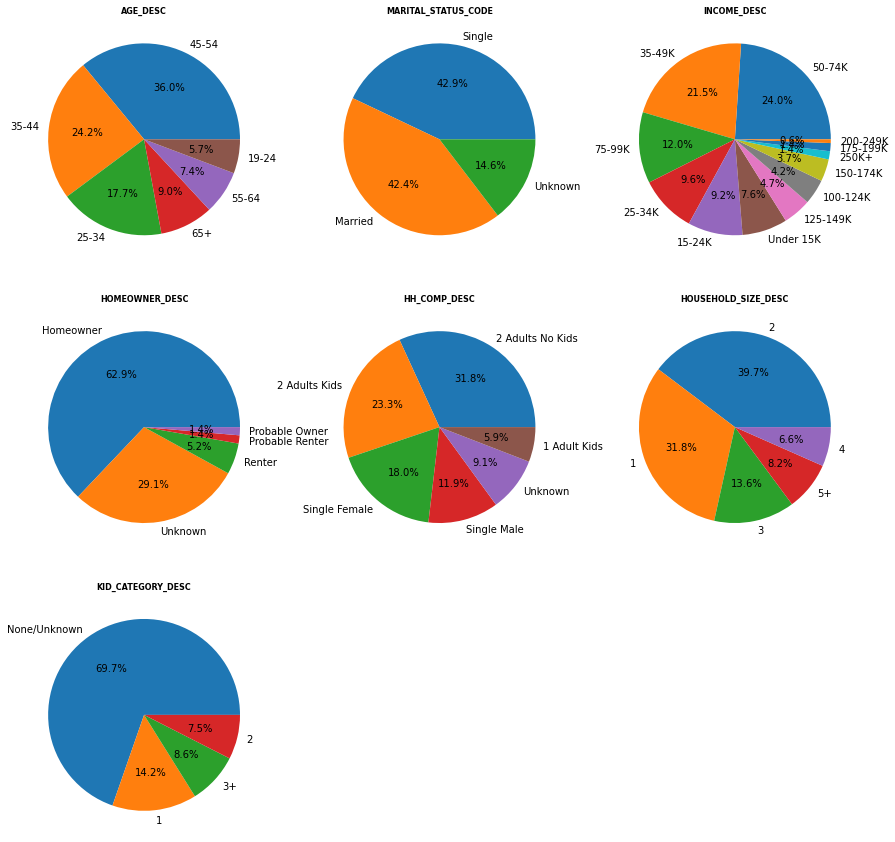

In [4]:
pie_categorical(df["hh_demographic"].drop("household_key",axis=1))

From here, we have a good view of our variable distributions and we can dig up some interesting information : 
- Majority of customers own their house
- Majority of customers are aged between 45 and 54 years old
- Majority of customers don't have children

### Campaign data
The tables campaign_table and campaign_desc contains all the campaign information. As we want to predict the customers that won't redeem their coupons for the next 5 planned campaigns, we will create our model based on all the previous campaigns. 
We can see that the last five campaigns are campaigns number 21, 22, 23, 24 and 25.

In [5]:
df["campaign_desc"] = pd.read_csv("campaign_desc.csv")
campaign_desc=df["campaign_desc"]
#Sort campaign by start date
campaign_desc=campaign_desc.sort_values(by=['START_DAY','CAMPAIGN'],ascending=True)
campaign_desc

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
29,TypeA,26,224,264
28,TypeC,27,237,300
27,TypeB,28,259,320
26,TypeB,29,281,334
25,TypeA,30,323,369
23,TypeB,1,346,383
24,TypeB,2,351,383
20,TypeC,3,356,412
22,TypeB,4,372,404
21,TypeB,5,377,411


We will exclude the last 5 campaigns and keep them for our validation dataset.

In [6]:
#keep only campaigns before Days 615
campaign_desc = campaign_desc[campaign_desc['START_DAY']<615]

The table campaign_table tells us which customers received a specific campaign.

In [7]:
df["campaign_table"] = pd.read_csv("campaign_table.csv")
campaign_table=df["campaign_table"]
campaign_table.head(10)

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26
5,TypeA,187,26
6,TypeA,183,26
7,TypeA,142,26
8,TypeA,140,26
9,TypeA,134,26


From this point we can merge the two campaign tables

In [8]:
#We call campaign the new dataframe merging the dataset
campaign = pd.merge(campaign_desc[['CAMPAIGN','START_DAY']],campaign_table[['household_key','CAMPAIGN']],on="CAMPAIGN",how="left")
#Count number of campaign per household
campaign['#campaign']=campaign.groupby(by='household_key')['CAMPAIGN'].transform('count')
#Delete useless column
campaign=campaign.drop(columns=['CAMPAIGN','START_DAY'])
#Delete duplicates
campaign.drop_duplicates(subset=['household_key', '#campaign'], keep="first", inplace=True)
campaign

,household_key,#campaign
0,17,5
1,27,7
2,212,5
3,208,7
4,192,3
...,...,...
6110,1744,1
6115,1594,1
6119,1479,1
6121,1447,1


### Coupon redemption data
This table contains all the coupons that have been redeemed by each customer. We will use it to count how many coupons a customer redeemed for each campaign.
we will follow the below steps :
- Loading the dataset
- Retrieving coupons redeemed before Day 615
- Count the number of campaign for which at least one coupon has been redeemed
- Merge our campaign table, coupon redemption table and demographic table
- Define if a customer is sensitive to coupon or not

In [9]:
#Read the coupon_redempt table
df["coupon_redempt"] = pd.read_csv("coupon_redempt.csv")
coupon_redempt=df["coupon_redempt"]
#Keep only coupon redeemed before DAY 615
coupon_redempt=coupon_redempt[coupon_redempt['DAY']<615]
#Drop useless columns
coupon_redempt=coupon_redempt.drop(columns=['DAY','COUPON_UPC'])
#Keep only one occurence of coupon redeemed by campaign
coupon_redempt.drop_duplicates(subset=['household_key', 'CAMPAIGN'], keep="first", inplace=True)
#Count number of campaign the customer redeemed at least one coupon
redemption_per_household=coupon_redempt.groupby(['household_key'], as_index=False)['CAMPAIGN'].agg({'redeemed': pd.Series.nunique})
redemption_per_household

,household_key,redeemed
0,1,2
1,8,1
2,13,6
3,14,1
4,18,3
...,...,...
392,2481,2
393,2488,4
394,2489,5
395,2496,3


In [10]:
#Merging of campaign and coupon redemption tables
temp = pd.merge(campaign, redemption_per_household, on=['household_key'],how="left")
#Creation of our output variable
temp["Sensitivity"]= np.where(temp["redeemed"]>0, 'Sensible', 'Not sensible')
#Creation of our aggregated dataset. We use the inner join to keep only customers for which we have the demographics data and thoose who were part of at least one campaign
dataset= pd.merge(demographic, temp[['household_key','Sensitivity']], on=['household_key'],how="inner")

### Transactions data
This table contains all the transactions made by customers during 2 years. it contains 12 columns and 2 595 732 rows.
We will use the transactional dataset to create some features for our model :
- Total sales between day 1 and day 615
- Total number of visits in the shops
- Median basket spend by customer
- Average product price purchased by customer

To clean the dataset, we will follow the below steps :
- Load the data
- Keep sales before day 615
- Exclude transaction with sales value and quantity inferior or equal to 0

In [11]:
# load the dataset
df["transaction_data"] = pd.read_csv("transaction_data.csv")
transaction=df["transaction_data"]
#Keep transaction before day 615
transaction=transaction[transaction['DAY']<615]
#Exclude transactions related to returns
transaction=transaction[transaction['SALES_VALUE']>0]
transaction=transaction[transaction['QUANTITY']>0]
transaction.head(20)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [12]:
#Calculate total sales per customer
total_sales=transaction.groupby(by='household_key', as_index=False)['SALES_VALUE'].sum().rename(columns={'SALES_VALUE': 'Total_sales'})
#Calculate total number of visits per customer
total_visits=transaction.groupby(['household_key'], as_index=False)['BASKET_ID'].agg({'total_visits': pd.Series.nunique})
#Calculate median basket amount per customer
temp_basket=transaction.groupby(['household_key','BASKET_ID'], as_index=False)['SALES_VALUE'].sum()
temp_median_basket=temp_basket.groupby(['household_key'], as_index=False)['SALES_VALUE'].median().rename(columns={'SALES_VALUE': 'median_basket'})
#Calculate average product price bought per customer
temp_product=transaction.groupby(['household_key'], as_index=False)['SALES_VALUE'].mean().rename(columns={'SALES_VALUE': 'avg_price'})
dataset=dataset.merge(total_sales,on='household_key').merge(total_visits,on='household_key').merge(temp_median_basket,on='household_key').merge(temp_product,on='household_key')
dataset=dataset.drop(columns=['household_key'])
dataset

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Sensitivity,Total_sales,total_visits,median_basket,avg_price
0,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,Sensible,3612.54,71,48.500,2.526252
1,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,2420.12,42,44.320,2.713139
2,25-34,Single,25-34K,Unknown,2 Adults Kids,3,1,Sensible,4387.35,96,34.090,2.875066
3,25-34,Single,75-99K,Homeowner,2 Adults Kids,4,2,Sensible,10864.94,224,40.000,5.742569
4,45-54,Unknown,50-74K,Homeowner,Single Female,1,None/Unknown,Not sensible,1486.02,93,13.730,2.936798
...,...,...,...,...,...,...,...,...,...,...,...,...
746,35-44,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,1569.24,27,51.240,3.666449
747,45-54,Married,75-99K,Homeowner,Unknown,3,1,Sensible,3898.51,56,72.095,2.935625
748,45-54,Single,35-49K,Unknown,Single Male,1,None/Unknown,Not sensible,5947.91,190,17.130,3.474246
749,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,2348.11,145,9.270,3.029819


# 2. Understand the data
Now our dataset is ready, let's discover it with descriptive statistics

### A. Shape of our data
Let's use the shape() method to know the dimensions of our dataset :

In [13]:
print(dataset.shape)

(751, 12)


We have 12 variables and 751 observations in our dataset

### B. Data types and data completness
Let's use the info() method to get more information about our dataframe as variables types and data completness :

In [14]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 0 to 750
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE_DESC             751 non-null    object 
 1   MARITAL_STATUS_CODE  751 non-null    object 
 2   INCOME_DESC          751 non-null    object 
 3   HOMEOWNER_DESC       751 non-null    object 
 4   HH_COMP_DESC         751 non-null    object 
 5   HOUSEHOLD_SIZE_DESC  751 non-null    object 
 6   KID_CATEGORY_DESC    751 non-null    object 
 7   Sensitivity          751 non-null    object 
 8   Total_sales          751 non-null    float64
 9   total_visits         751 non-null    int64  
 10  median_basket        751 non-null    float64
 11  avg_price            751 non-null    float64
dtypes: float64(3), int64(1), object(8)
memory usage: 76.3+ KB
None


We have 8 categorical variables and 4 numerical values.
We don't have any missing values among our 751 observations.

### C. Statistical Summary of our data
Let's use the describe() method to have a basic description of our dataset. It will enable us to have various summary statistics :

In [15]:
dataset.describe()

,Total_sales,total_visits,median_basket,avg_price
count,751.000000,751.000000,751.000000,751.000000
mean,4856.599800,152.937417,27.839141,3.161039
std,3164.519227,114.177278,19.329986,0.755985
min,603.220000,26.000000,1.380000,1.312542
25%,2549.375000,86.000000,14.995000,2.673614
50%,4055.480000,121.000000,23.545000,3.077172
75%,6135.135000,186.000000,34.975000,3.539830
max,23805.830000,1161.000000,128.880000,9.412544


### D. Class distribution
On classification problems, analyzing the class distribution is always an important step as highly imbalanced data are common and need special treatment. Let's check if data are imbalanced :

In [16]:
import collections
from collections import Counter

target = dataset['Sensitivity']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.2f%%' % (k, v, per))

Class=Sensible, Count=286, Percentage=38.08%
Class=Not sensible, Count=465, Percentage=61.92%


62% of our customers are not sensitive to coupons. Hence our dataset is sligthly imbalanced with more customers not sensible to coupons. We will keep that in mind when choosing our cross validation technique.

### E. Variable transformation and split
These two intermediate steps are needed in order to :
1. Separate the columns of our dataset into input patterns (X) and output patterns (Y)
2. Transform our eight categorical variables in numeric variables

In [17]:
#1. Split data into X and Y
X=dataset.drop(columns=['Sensitivity'])
Y=dataset['Sensitivity']

#2.A. Encode string class values as integers
label_encoder = preprocessing.LabelEncoder()
label_encoder = label_encoder.fit(dataset['Sensitivity'])
label_encoded_y = label_encoder.transform(dataset['Sensitivity'])

#2.A. Encode Income values as integers
X['INCOME_DESC'].replace(['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)

#2.A. Encode Income values as integers
X['AGE_DESC'].replace(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'],[0,1,2,3,4,5],inplace=True)

#2.A. Label encoding the other categorical data
labelencoder_X_1 = LabelEncoder()
X['MARITAL_STATUS_CODE'] = labelencoder_X_1.fit_transform(X['MARITAL_STATUS_CODE'])
labelencoder_X_2 = LabelEncoder()
X['HOMEOWNER_DESC'] = labelencoder_X_2.fit_transform(X['HOMEOWNER_DESC'])
labelencoder_X_3 = LabelEncoder()
X['HH_COMP_DESC'] = labelencoder_X_3.fit_transform(X['HH_COMP_DESC'])
labelencoder_X_4 = LabelEncoder()
X['HOUSEHOLD_SIZE_DESC'] = labelencoder_X_4.fit_transform(X['HOUSEHOLD_SIZE_DESC'])
X["KID_CATEGORY_DESC"].replace(['None/Unknown','3+'],[0,3],inplace=True)
X['HOUSEHOLD_SIZE_DESC'] = X.HOUSEHOLD_SIZE_DESC.astype(float)
X['KID_CATEGORY_DESC'] = X.KID_CATEGORY_DESC.astype(float)

### E. Skew of univariate distribution
This steps is one of the most important as many algorithm performance would depend on the normal distribution of the variables.
XGboost is a non-parametric model and non-parametric models are rarely affected by skewed features. However normalizing features will not have a negative effect on our models’ performance. Let's check if our data are skewed :

In [18]:
#Let's plot the Skewness by decreasing order
num_feats=X.dtypes[X.dtypes!='object'].index
skew_feats=X[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
print(skewness)

                         Skew
total_visits         3.492819
median_basket        1.951511
KID_CATEGORY_DESC    1.691072
Total_sales          1.634103
avg_price            1.421711
HOUSEHOLD_SIZE_DESC  1.063468
INCOME_DESC          0.675299
HOMEOWNER_DESC       0.626789
MARITAL_STATUS_CODE  0.431214
HH_COMP_DESC         0.392703
AGE_DESC             0.103937


Value close to 0 show less skew.

Plotting the distribution is the fastest way to know if an attribute is Gaussian or skewed.

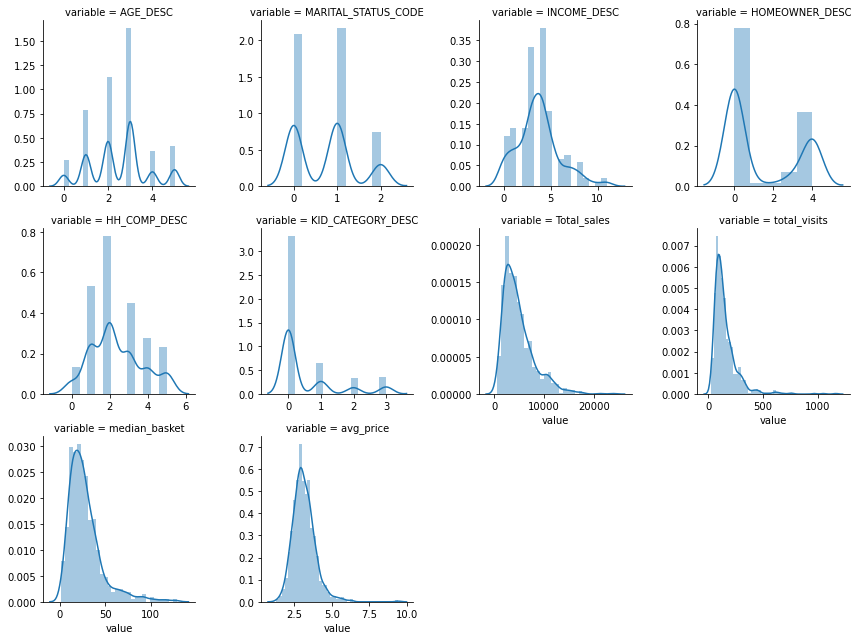

In [19]:
df = pd.DataFrame(data=X, columns=['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC','Total_sales','total_visits','median_basket','avg_price'])
#Permet de tracer les courbes de distribution de toutes les variables
nd = pd.melt(df, value_vars =df )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

We can see most of our variables have a gaussian-like distribution with a long right tail. This is confirmed with the positive values of the skewness

### F. Correlation between attributes
Now we want to be sure we don't have variables with similar information. For that we will plot the correlation matrix.
Correlation refers to the relationship between two variables and how they move together.
Even if XGBoost manages very well correlated features, it's always a good step to check for multicollinearity

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Total_sales,total_visits,median_basket,avg_price
AGE_DESC,1.000000,-0.104143,0.012655,-0.234616,0.142031,-0.125674,-0.183611,-0.060715,-0.006951,0.007275,0.011052
MARITAL_STATUS_CODE,-0.104143,1.000000,-0.175876,0.278725,0.281521,-0.437588,-0.243869,-0.124342,-0.001902,-0.136015,-0.097296
INCOME_DESC,0.012655,-0.175876,1.000000,-0.264682,-0.059110,0.126257,0.071628,0.254466,-0.045327,0.307867,0.228124
HOMEOWNER_DESC,-0.234616,0.278725,-0.264682,1.000000,0.225080,-0.268131,-0.129415,-0.148902,0.051421,-0.246585,-0.195464
HH_COMP_DESC,0.142031,0.281521,-0.059110,0.225080,1.000000,-0.715184,-0.586226,-0.140562,-0.009649,-0.126503,0.006928
HOUSEHOLD_SIZE_DESC,-0.125674,-0.437588,0.126257,-0.268131,-0.715184,1.000000,0.919482,0.165068,-0.003560,0.145334,0.029668
KID_CATEGORY_DESC,-0.183611,-0.243869,0.071628,-0.129415,-0.586226,0.919482,1.000000,0.155548,0.014054,0.100375,-0.014497
Total_sales,-0.060715,-0.124342,0.254466,-0.148902,-0.140562,0.165068,0.155548,1.000000,0.516141,0.331769,0.344632
total_visits,-0.006951,-0.001902,-0.045327,0.051421,-0.009649,-0.003560,0.014054,0.516141,1.000000,-0.332375,0.001330
median_basket,0.007275,-0.136015,0.307867,-0.246585,-0.126503,0.145334,0.100375,0.331769,-0.332375,1.000000,0.247667


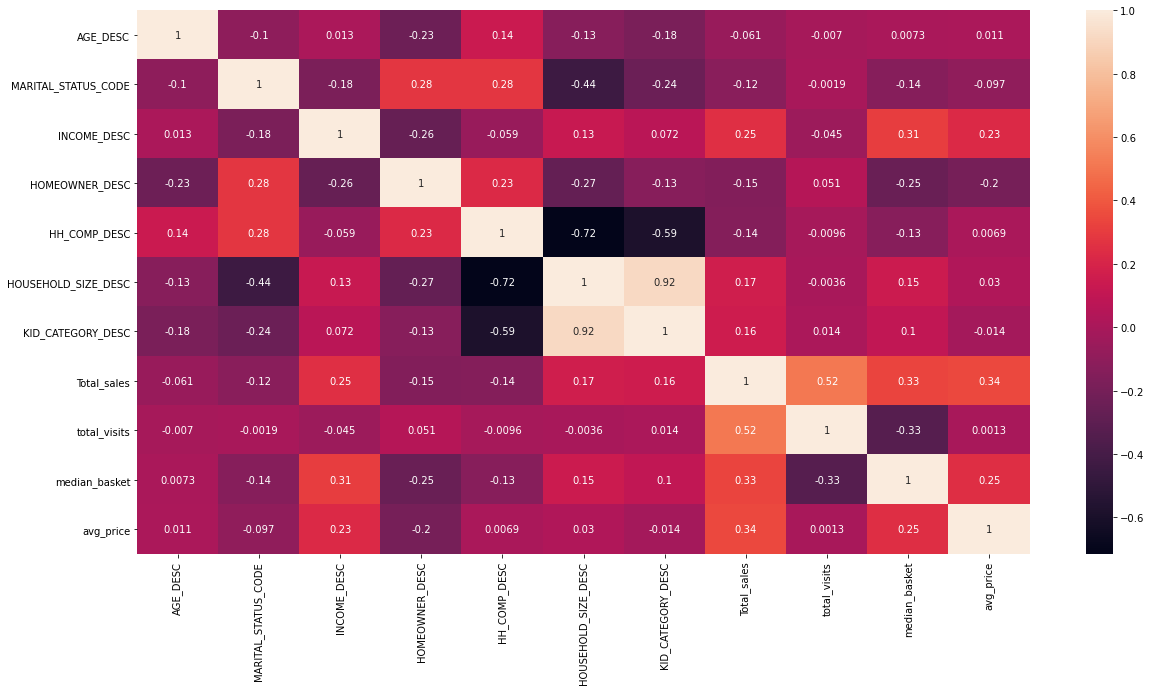

In [20]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= X.corr(method='pearson')
sns.heatmap(c,annot=True)
c

We can see that Households_SIZE_DESC,KID_CATEGORY_DESC and HH_COMP_DESC are correlated. Even if as said, XGboost handle correlated features, we will remove HOUSEHOLD_SIZE_DESC

In [21]:
#remove attributes
X=X.drop(columns=['HOUSEHOLD_SIZE_DESC'])

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,KID_CATEGORY_DESC,Total_sales,total_visits,median_basket,avg_price
AGE_DESC,1.000000,-0.104143,0.012655,-0.234616,0.142031,-0.183611,-0.060715,-0.006951,0.007275,0.011052
MARITAL_STATUS_CODE,-0.104143,1.000000,-0.175876,0.278725,0.281521,-0.243869,-0.124342,-0.001902,-0.136015,-0.097296
INCOME_DESC,0.012655,-0.175876,1.000000,-0.264682,-0.059110,0.071628,0.254466,-0.045327,0.307867,0.228124
HOMEOWNER_DESC,-0.234616,0.278725,-0.264682,1.000000,0.225080,-0.129415,-0.148902,0.051421,-0.246585,-0.195464
HH_COMP_DESC,0.142031,0.281521,-0.059110,0.225080,1.000000,-0.586226,-0.140562,-0.009649,-0.126503,0.006928
KID_CATEGORY_DESC,-0.183611,-0.243869,0.071628,-0.129415,-0.586226,1.000000,0.155548,0.014054,0.100375,-0.014497
Total_sales,-0.060715,-0.124342,0.254466,-0.148902,-0.140562,0.155548,1.000000,0.516141,0.331769,0.344632
total_visits,-0.006951,-0.001902,-0.045327,0.051421,-0.009649,0.014054,0.516141,1.000000,-0.332375,0.001330
median_basket,0.007275,-0.136015,0.307867,-0.246585,-0.126503,0.100375,0.331769,-0.332375,1.000000,0.247667
avg_price,0.011052,-0.097296,0.228124,-0.195464,0.006928,-0.014497,0.344632,0.001330,0.247667,1.000000


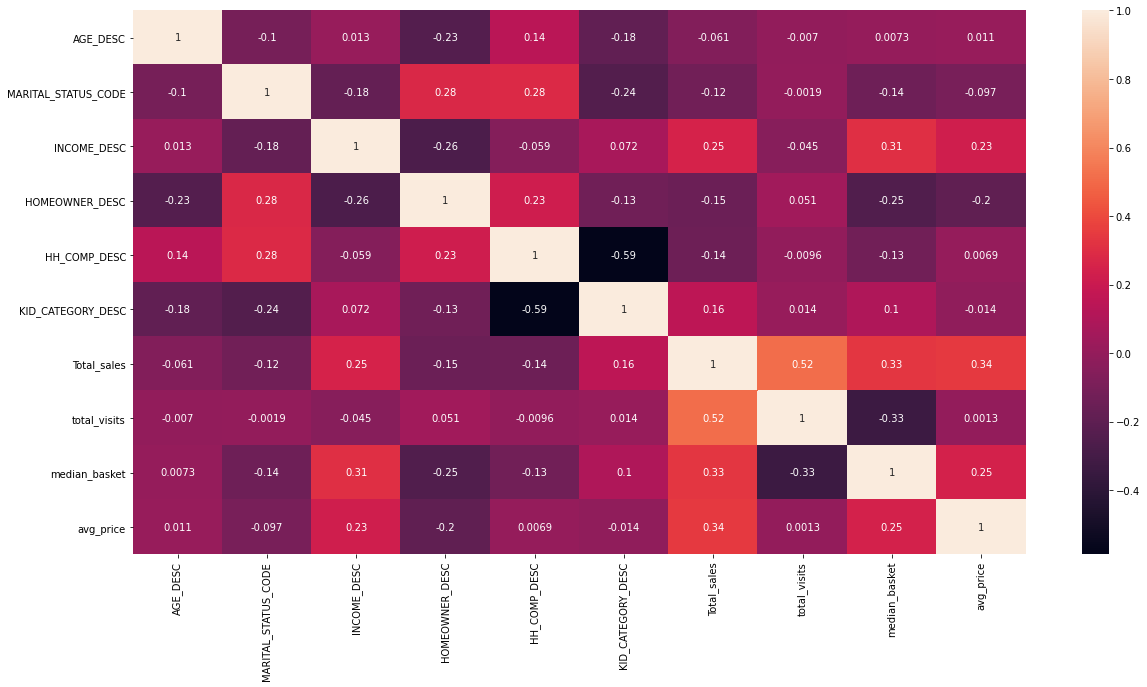

In [22]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= X.corr(method='pearson')
sns.heatmap(c,annot=True)
c

# Data Preprocessing

### 1. Split data into train test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,label_encoded_y ,
test_size=0.3, random_state=7,shuffle=True)

### 2. Data transform
To normalize data we will use the power transform method

In [24]:
#instantiate 
pt = PowerTransformer(method='yeo-johnson', standardize=True) 

#Fit the data to the powertransformer
rescaler = pt.fit(X_train)

#Lets get the Lambdas that were found
print (rescaler.lambdas_)

calc_lambdas = rescaler.lambdas_

#Transform the data 
X_train_resc = rescaler.transform(X_train)
X_test_resc=rescaler.transform(X_test)

#Pass the transformed data into a new dataframe 
df_xt = pd.DataFrame(data=X_train_resc, columns=['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC','Total_sales','total_visits','median_basket','avg_price'])
df_xt.head()

df_xt.describe()

[ 0.80567994 -0.00742699  0.62559009 -0.8781086   0.54468516 -2.93541141
  0.04739063 -0.1815103   0.1589954  -0.38965466]


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,KID_CATEGORY_DESC,Total_sales,total_visits,median_basket,avg_price
count,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02,5.250000e+02
mean,-4.297092e-16,1.141944e-16,-2.059728e-16,1.691768e-17,-3.967197e-16,8.881784e-18,-6.555603e-17,-1.895627e-15,1.158861e-16,-5.582836e-16
std,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00,1.000954e+00
min,-2.027385e+00,-1.127746e+00,-1.991625e+00,-8.105605e-01,-2.110671e+00,-6.251768e-01,-2.937835e+00,-3.062242e+00,-3.137585e+00,-3.599637e+00
25%,-3.250900e-01,-1.127746e+00,-2.418011e-01,-8.105605e-01,-1.036991e+00,-6.251768e-01,-7.112249e-01,-6.387461e-01,-6.669308e-01,-6.096777e-01
50%,4.309121e-01,5.557271e-01,2.102466e-01,-8.105605e-01,-1.931713e-01,-6.251768e-01,8.898098e-03,-4.347020e-02,1.636481e-02,-5.450846e-03
75%,4.309121e-01,5.557271e-01,6.294273e-01,1.291817e+00,5.291891e-01,1.462306e+00,6.436815e-01,6.720304e-01,6.293441e-01,6.408521e-01
max,1.842761e+00,1.536486e+00,2.740381e+00,1.291817e+00,1.760070e+00,1.735189e+00,3.003502e+00,3.085173e+00,3.055671e+00,4.513681e+00


Let's vizualize our features after normalization

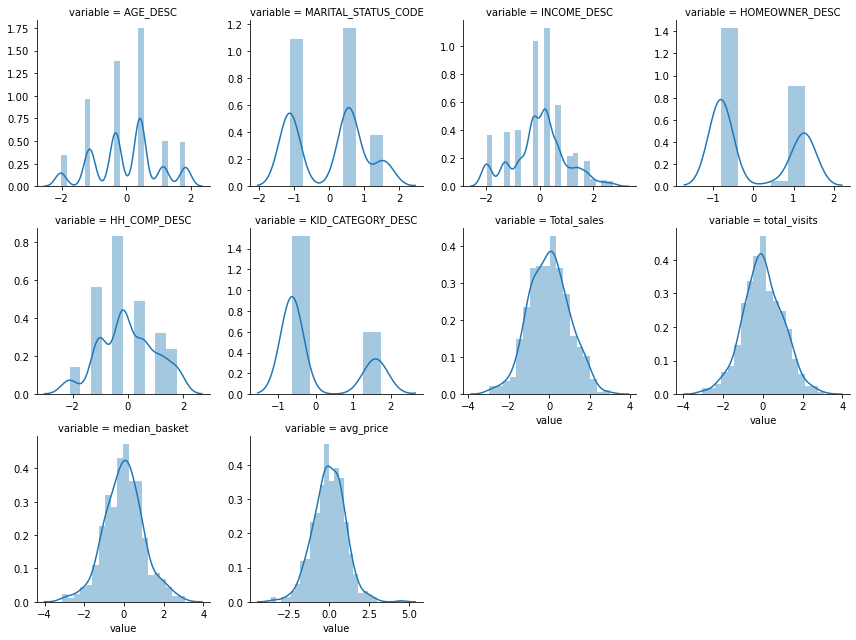

In [25]:
df_xt = pd.DataFrame(data=X_train_resc,columns=['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC','Total_sales','total_visits','median_basket','avg_price'])
#Permet de tracer les courbes de distribution de toutes les variables
nd = pd.melt(df_xt, value_vars =df_xt )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

### 3. Feature selection
We will use the PCA transformation. first step is to choose the number of components

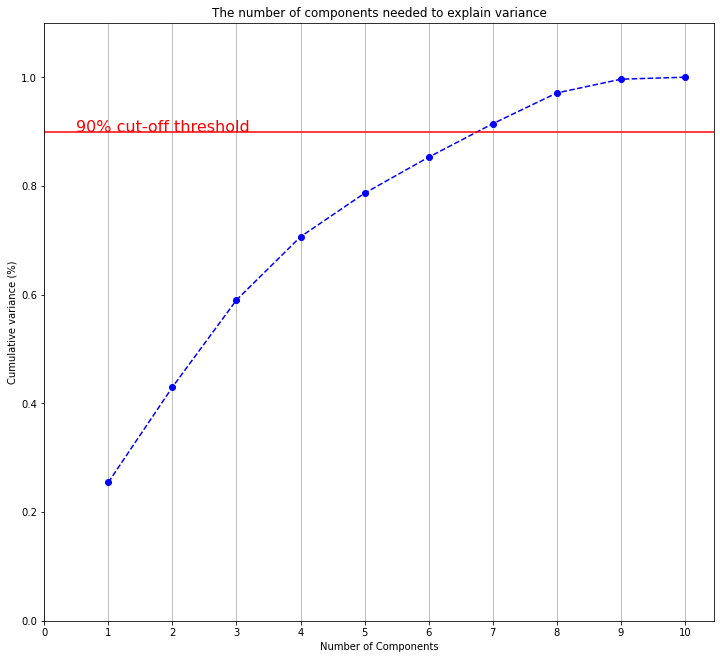

In [26]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_resc)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,11)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.90, '90% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

We will choose the number of components that explains 90% of the variance. From the graph we can see that we need 7 components.

In [27]:
from sklearn.decomposition import PCA
# on standardized data
pca_std = PCA(n_components=7).fit(X_train_resc)
X_train_PCA = pca_std.transform(X_train_resc)
X_test_PCA = pca_std.transform(X_test_resc)
pca_std.explained_variance_ratio_

array([0.25450609, 0.17523455, 0.16027727, 0.11641416, 0.08013689,
       0.06630728, 0.06154442])

# Model creation

In [28]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#check the performance of the XGBoost model without tune parameters
# fit model on training data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)


Accuracy = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='accuracy')
Precision = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='precision')

print("Accuracy: %.1f%% (%.1f%%)" % (Accuracy.mean()*100, Accuracy.std()*100))
print("Precision: %.1f%% (%.1f%%)" % (Precision.mean()*100, Precision.std()*100))

Accuracy: 66.7% (4.3%)
Precision: 55.8% (8.7%)


To assess the performance of our model, we will concentrate on two evaluation metrics :
- Accuracy
- Precision  

Precision is very interesting here as we would like to minimize as much as possible Type 1 error also known as False positive. Indeed, we would like to avoid the case where a customer is predicted to be sensitive to coupons while in fact he is not. This would lead to money loss as we would print and send him/her coupons for nothing. 
Our model report an accuracy of 66.7% and a precision of 55.8%. This means that when our model predict that a customer is sensitive to coupon, it's correct 55.8% of the time.
We will try to improve our model performance with some tuning.

### Model hyperparameter tuning

In [49]:
# grid search to tune algorithm
model = xgb.XGBClassifier()
n_estimators = [100, 200, 300, 400,450, 500,1000]
learning_rate = [0.001, 0.01, 0.1]
max_depth= range(2,8)
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=max_depth)
eval_set=[(X_train_PCA, y_train), (X_test_PCA, y_test)]
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
grid_search = GridSearchCV(model, param_grid,scoring='accuracy', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_PCA, y_train,early_stopping_rounds= 10,eval_metric= ["error", "logloss"],eval_set=eval_set,verbose=True)
                              


# summarize result
print("Best: %.2f%% using %s" % (grid_result.best_score_*100, grid_result.best_params_))



[0]	validation_0-error:0.30286	validation_0-logloss:0.69149	validation_1-error:0.37168	validation_1-logloss:0.69209
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.30286	validation_0-logloss:0.68987	validation_1-error:0.37168	validation_1-logloss:0.69107
[2]	validation_0-error:0.30286	validation_0-logloss:0.68828	validation_1-error:0.37168	validation_1-logloss:0.69003
[3]	validation_0-error:0.30286	validation_0-logloss:0.68671	validation_1-error:0.37168	validation_1-logloss:0.68905
[4]	validation_0-error:0.30286	validation_0-logloss:0.68518	validation_1-error:0.37168	validation_1-logloss:0.68806
[5]	validation_0-error:0.30286	validation_0-logloss:0.68367	validation_1-error:0.37168	validation_1-logloss:0.68713
[6]	validation_0-error:0.30286	validation_0-logloss:0.68219	validation_1-error:0.37168	validation_1-logloss:0.68618
[7]	validation_0-error:

In [46]:
# fit model on training data
model = xgb.XGBClassifier(learning_rate = 0.01,\
                          max_depth=2,\
                          n_estimators=500,\
                          objective = 'binary:logistic',\
                          )
kfold =  StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
eval_set=[(X_train_PCA, y_train), (X_test_PCA, y_test)]

Accuracy = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='accuracy')
Precision = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='precision')

print("Accuracy: %.1f%% (%.1f%%)" % (Accuracy.mean()*100, Accuracy.std()*100))
print("Precision: %.1f%% (%.1f%%)" % (Precision.mean()*100, Precision.std()*100))



Accuracy: 68.6% (3.9%)
Precision: 61.6% (9.8%)


After hyperparameter tuning, our accuracy improved to 69% and our precision to 62%. Let's now discover the performance of our model on the test set.

accuracy: 65.93%
Precision: 68.09%
              precision    recall  f1-score   support

           1       0.68      0.34      0.45        94
           0       0.65      0.89      0.75       132

    accuracy                           0.66       226
   macro avg       0.67      0.61      0.60       226
weighted avg       0.66      0.66      0.63       226



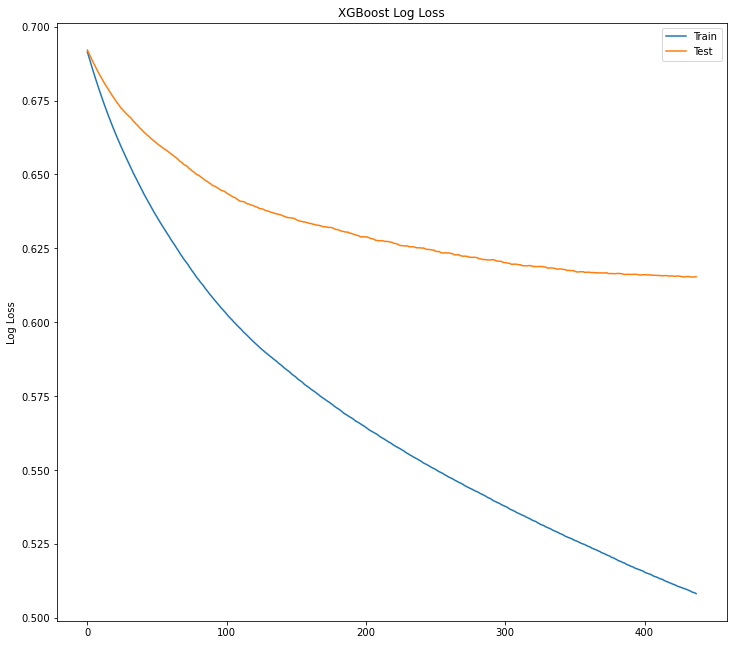

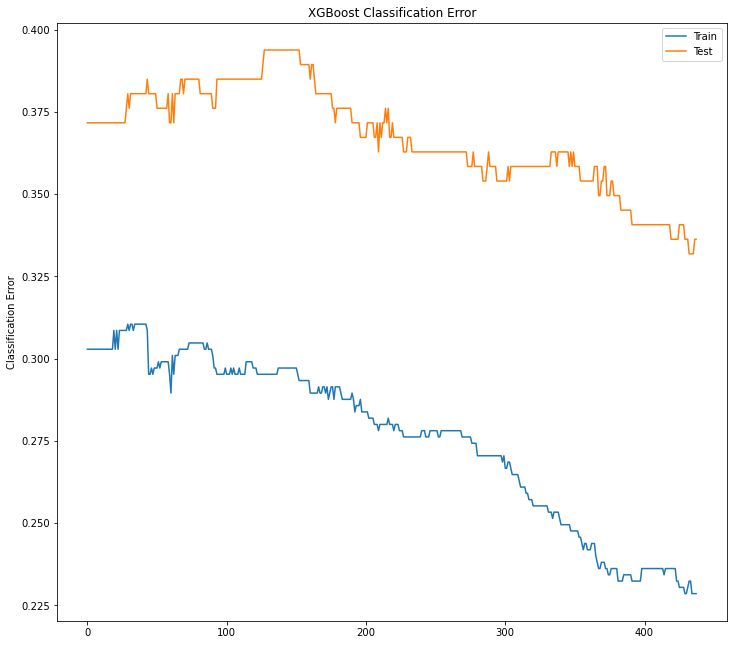

In [120]:
import warnings
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
model = xgb.XGBClassifier(learning_rate = 0.01,\
                          max_depth=2,\
                          n_estimators=500,\
                          objective = 'binary:logistic',\
                          )

eval_set = [(X_train_PCA, y_train), (X_test_PCA, y_test)]
model.fit(X_train_PCA, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
predictions = model.predict(X_test_PCA)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)

roc_auc=roc_auc_score(y_test,predictions)
print("accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print(classification_report(y_test, predictions,   labels=[1,0]))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

Performance on test set reports an accuracy of 66% and a precision of 68%

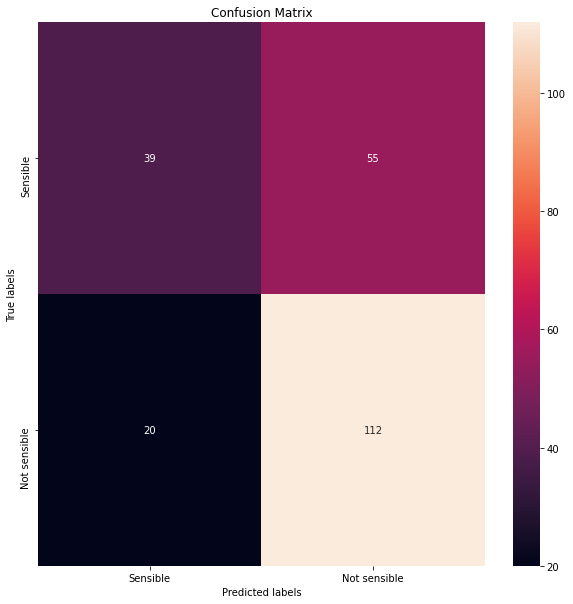

In [87]:
import seaborn as sb
import sklearn as sk
import matplotlib.pyplot as plt
# confusion marix for the test data
cm = sk.metrics.confusion_matrix(y_test, predictions,  labels=[1,0])

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sensible','Not sensible']); 
ax.yaxis.set_ticklabels(['Sensible','Not sensible']);

In conclusion we can use this model to predict if a customer is sensitive to coupons or not. Compared to before, when we were sending coupons to customers, only 38% of them used to redeem their coupons meaning 62% of them were not interested. Now we can use our prediction model and target with a precision of 68% the customers who will use their coupons meaning we have an error of 32%. We have very much improved the targeting of our customers !